# Swizterland Points of Interest -- Voronoi map

In [2]:
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

In [3]:
from shapely.ops import cascaded_union

In [4]:
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# read the points file

In [25]:
points = gpd.read_file("../data/switzerland-points-shape/points.shp")
points.head()

,osm_id,name,type,geometry
0,280587,Figuiers,bus_stop,POINT (6.61205 46.51706)
1,280590,Mont d'Or,bus_stop,POINT (6.61513 46.51689)
2,280615,None,traffic_signals,POINT (6.62316 46.52120)
3,280657,None,traffic_signals,POINT (6.62717 46.52703)
4,280690,None,mini_roundabout,POINT (6.68962 46.50159)


# read the swiss boundary

In [109]:
boundary = gpd.read_file("../data/switzerland-boundaries-shape/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp")
boundary.head()

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,...,OBJEKTART,REVISION_Q,ICC,KANTONSNUM,SEE_FLAECH,KANTONSFLA,KT_TEIL,NAME,EINWOHNERZ,geometry
0,{0B2364ED-49E0-4D53-A33C-C684DD530B57},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,18,NaN,710530.0,0,Graubünden,198379.0,"POLYGON Z ((709776.070 185645.951 3063.268, 70..."
1,{DDD56CEF-0E61-4EED-85ED-F67A459C93ED},2019-11-06,2012-10-26,2012,10,2020,1,Verbessert,swisstopo,2019,...,Kanton,2019_Aufbau,CH,2,11897.0,595951.0,1,Bern,1034977.0,"POLYGON Z ((646448.480 181951.451 2349.027, 64..."
2,{54B25E50-30A7-4995-ADE3-5FFF6E13A995},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,23,1060.0,522463.0,0,Valais,343955.0,"POLYGON Z ((672688.370 144974.021 2926.027, 67..."
3,{921DFEF2-6D91-4CB8-9CFC-2A831C412020},2019-11-06,2012-10-26,2012,10,2020,1,Verbessert,swisstopo,2019,...,Kanton,2019_Aufbau,CH,22,39097.0,321202.0,1,Vaud,799145.0,"POLYGON Z ((571641.020 116683.450 2929.729, 57..."
4,{95F10F52-8B2F-4D6A-AF7E-D4F915E42F89},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,21,7147.0,281216.0,0,Ticino,353343.0,"POLYGON Z ((672688.370 144974.021 2926.027, 67..."


## check coordinate reference systems

In [110]:
boundary.crs

<Projected CRS: EPSG:21781>
Name: CH1903 / LV03
Axis Info [cartesian]:
- Y[east]: Easting (metre)
- X[north]: Northing (metre)
Area of Use:
- name: Europe - Liechtenstein and Switzerland
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1903M
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [111]:
boundary = boundary.to_crs({'init': 'epsg:4326'})

In [112]:
boundary.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [113]:
points.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Plot to check if they overlap well

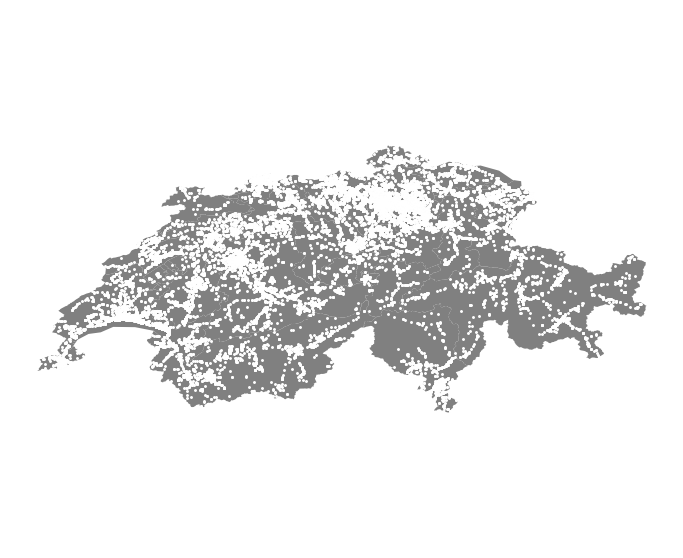

In [114]:
fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color="gray")
points.plot(ax=ax, markersize=3.5, color="white")
ax.axis("off")
plt.axis("equal")
plt.show()

## Sample points

In [122]:
points_sample = points.sample(n=500, random_state=7)
len(points_sample)

500

In [126]:
boundary = boundary.to_crs(epsg=3395)
gdf_proj = points_sample.to_crs(boundary.crs)

In [127]:
boundary.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - between 80°S and 84°N
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [128]:
boundary_shape = cascaded_union(boundary.geometry)
coords = points_to_coords(gdf_proj.geometry)

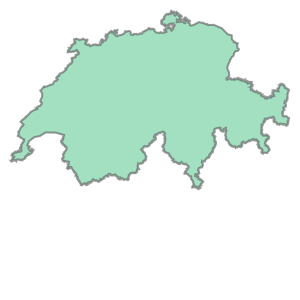

In [129]:
boundary_shape

# Plot Voronoi

In [132]:
# Calculate Voronoi Regions
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, boundary_shape)

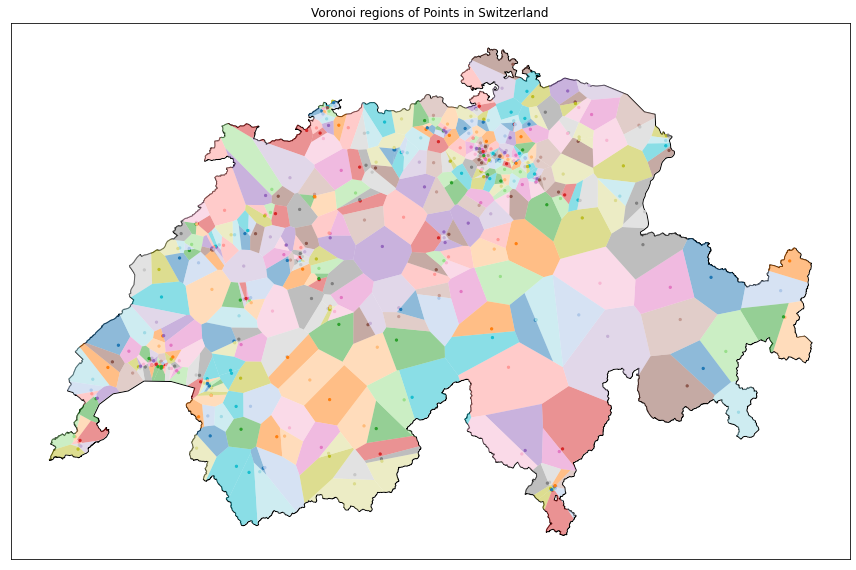

In [133]:
fig, ax = subplot_for_map(figsize=(12, 10))
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments)
ax.set_title('Voronoi regions of Points in Switzerland')
plt.tight_layout()
plt.show()

## A bit better formatted Voronoi plot

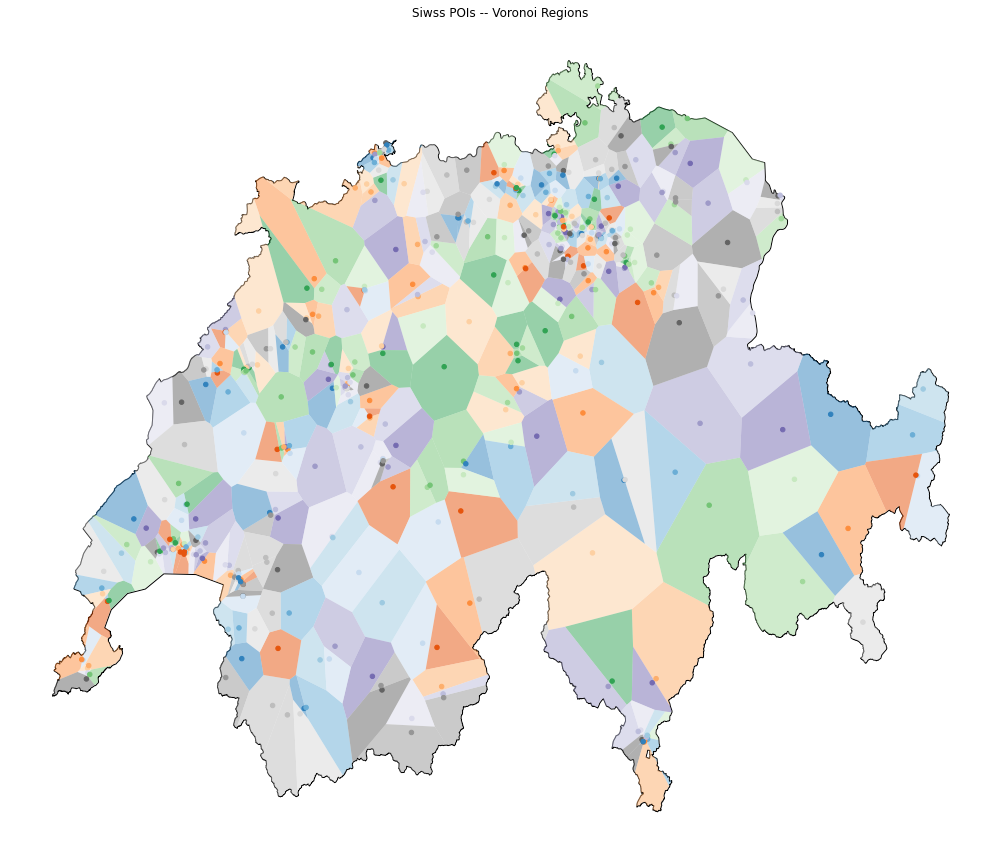

In [135]:
fig, ax = plt.subplots(figsize=(14,12))
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments,
 voronoi_and_points_cmap="tab20c",
 points_markersize=20)
ax.set_title("Siwss POIs -- Voronoi Regions")
ax.axis("off")
plt.tight_layout()
plt.show()